#<font color=#FF0099><b>C</b></font><font color=#00FF66><b>O</b></font><font color=#FFCC00><b>L</b></font><font color=#0066FF><b>O</b></font><font color=#FF6600><b>R</b></font><font color=#33CCFF><b>F</b></font><font color=#FF0033><b>U</b></font><font color=#00FFFF><b>L</b></font> <font color=#FF0099><b>I</b></font><font color=#00FF66><b>M</b></font><font color=#FFCC00><b>A</b></font><font color=#0066FF><b>G</b></font><font color=#FF6600><b>E</b></font> <font color=#FF0099><b>C</b></font><font color=#00FF66><b>O</b></font><font color=#FFCC00><b>L</b></font><font color=#0066FF><b>O</b></font><font color=#FF6600><b>R</b></font><font color=#33CCFF><b>I</b></font><font color=#FF0033><b>Z</b></font><font color=#00FF66><b>A</b></font><font color=#FFCC00><b>T</b></font><font color=#0066FF><b>I</b></font><font color=#FF6600><b>O</b></font><font color=#33CCFF><b>N</b></font>

####Credits:
- https://github.com/opencv/opencv/blob/master/samples/dnn/colorization.py
- https://github.com/richzhang/colorization/
- http://richzhang.github.io/colorization/

#### Model Resources:
- pts_in_hull.npy:					           https://github.com/richzhang/colorization/blob/caffe/colorization/resources/pts_in_hull.npy
- colorization_deploy_v2.prototxt:    https://github.com/richzhang/colorization/tree/caffe/colorization/models
- colorization_release_v2.caffemodel: https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl

## <font color=black><b>Colorization</b></font>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
!curl -o myimage.png https://images.pexels.com/photos/57905/pexels-photo-57905.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500
#!curl -o myimage.png https://onlinetools.com/images/examples-onlineimagetools/black-dog-gray-srgb.png
#!curl -o myimage.png https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png
#!curl -o myimage.png https://qph.cf2.quoracdn.net/main-qimg-85ab9d09a5717eb108c41f9d7e80c954-pjlq
#!curl -o myimage.png https://media.geeksforgeeks.org/wp-content/uploads/gray.jpeg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  353k  100  353k    0     0   210k      0  0:00:01  0:00:01 --:--:--  210k


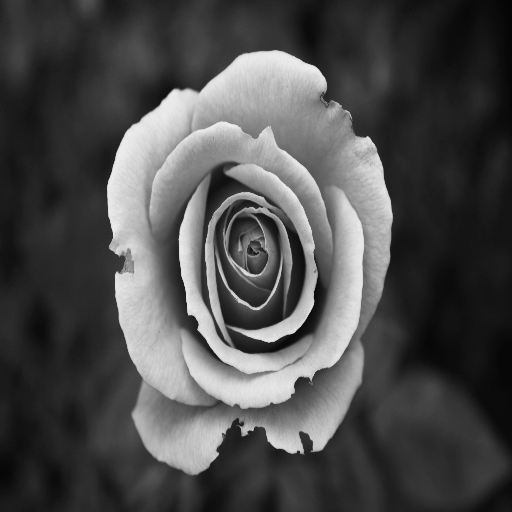

In [ ]:
BW_image = cv2.imread('myimage.png', cv2.IMREAD_GRAYSCALE)
if BW_image is None:
    print("Error loading image")
else:
    BW_image = cv2.resize(BW_image, (512, 512))
cv2_imshow(BW_image)

In [ ]:
!gdown --id 1YTAu44rq-MymBPdlm0pUCa9ue7Xrm8K-
!unzip colorization.zip
!rm -rf __MACOSX

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YTAu44rq-MymBPdlm0pUCa9ue7Xrm8K-
From (redirected): https://drive.google.com/uc?id=1YTAu44rq-MymBPdlm0pUCa9ue7Xrm8K-&confirm=t&uuid=a0a3589e-3d65-485c-8dd5-5584ba8fa544
To: /content/colorization.zip
100% 120M/120M [00:02<00:00, 40.5MB/s]
Archive:  colorization.zip
   creating: colorization/
  inflating: __MACOSX/._colorization  
  inflating: colorization/colorization_release_v2.caffemodel  
  inflating: __MACOSX/colorization/._colorization_release_v2.caffemodel  
  inflating: colorization/.DS_Store  
  inflating: __MACOSX/colorization/._.DS_Store  
  inflating: colorization/pts_in_hull.npy  
  inflating: __MACOSX/colorization/._pts_in_hull.npy  
  inflating: colorization/colorization_deploy_v2.prototxt  
  infl

In [ ]:
model  = '/content/colorization/colorization_release_v2.caffemodel'
prototxt  = '/content/colorization/colorization_deploy_v2.prototxt'
kernel  = '/content/colorization/pts_in_hull.npy'

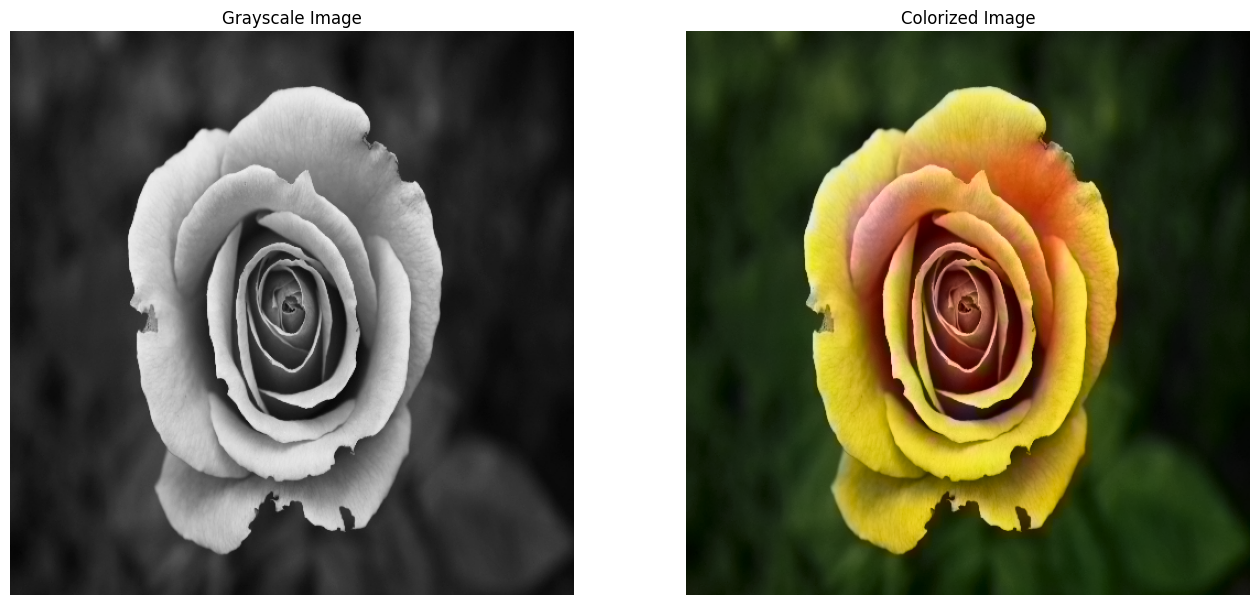

In [ ]:
net = cv2.dnn.readNetFromCaffe(prototxt, model)
points = np.load(kernel)

# Populate cluster centers as 1x1 convolution kernel
points = points.transpose().reshape(2, 313, 1, 1)
net.getLayer(net.getLayerId('class8_ab')).blobs = [points.astype(np.float32)]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

if len(BW_image.shape) == 2:
    BW_image = cv2.cvtColor(BW_image, cv2.COLOR_GRAY2BGR)

# (LAB -> L = lightness, a* b*)
normalized = BW_image.astype("float32") / 255.0
lab = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB) # Convert BGR to LAB

resized = cv2.resize(lab, (224, 224))

# Extract the L channel (lightness)
L = cv2.split(resized)[0]

# Adjust the brightness of the L channel by subtracting 50 from its pixel values
L -= 50

# Set the input for the neural network with the adjusted L channel
net.setInput(cv2.dnn.blobFromImage(L))

# Forward pass through the neural network to predict the 'ab' channels
ab = net.forward()[0, :, :, :].transpose((1,2,0))

# Resize the predicted 'ab' channels to match the size of the original input image
ab = cv2.resize(ab, (BW_image.shape[1], BW_image.shape[0]))

# Extract the L channel from the original LAB image
L = cv2.split(lab)[0]

# Combine the adjusted L channel and the predicted 'ab' channels to form the colorized image
colorized = np.concatenate((L[:,:,np.newaxis], ab), axis=2)
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = (255.0 * colorized).astype("uint8")


plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(BW_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB))
plt.title('Colorized Image')
plt.axis('off')

plt.show()